<a href="https://colab.research.google.com/github/MwangiMuriuki2003/MURIUKI/blob/main/JPMorgan_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import tensorflow as tf
import keras
import scipy
import google.colab

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Nat_Gas.csv to Nat_Gas.csv


In [23]:
import pandas as pd
df = pd.read_csv('Nat_Gas.csv')
print(df.head())
print(df.describe())

mean_value = df.mean(numeric_only=True)
median_value = df.median(numeric_only=True)
std_dev = df.std(numeric_only=True)
correlation = df.corr(numeric_only=True)

print("Mean:\n", mean_value)
print("Median:\n", median_value)
print("Standard Deviation:\n", std_dev)
print("Correlation Matrix:\n", correlation)

      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9
          Prices
count  48.000000
mean   11.207083
std     0.757897
min     9.840000
25%    10.650000
50%    11.300000
75%    11.625000
max    12.800000
Mean:
 Prices    11.207083
dtype: float64
Median:
 Prices    11.3
dtype: float64
Standard Deviation:
 Prices    0.757897
dtype: float64
Correlation Matrix:
         Prices
Prices     1.0


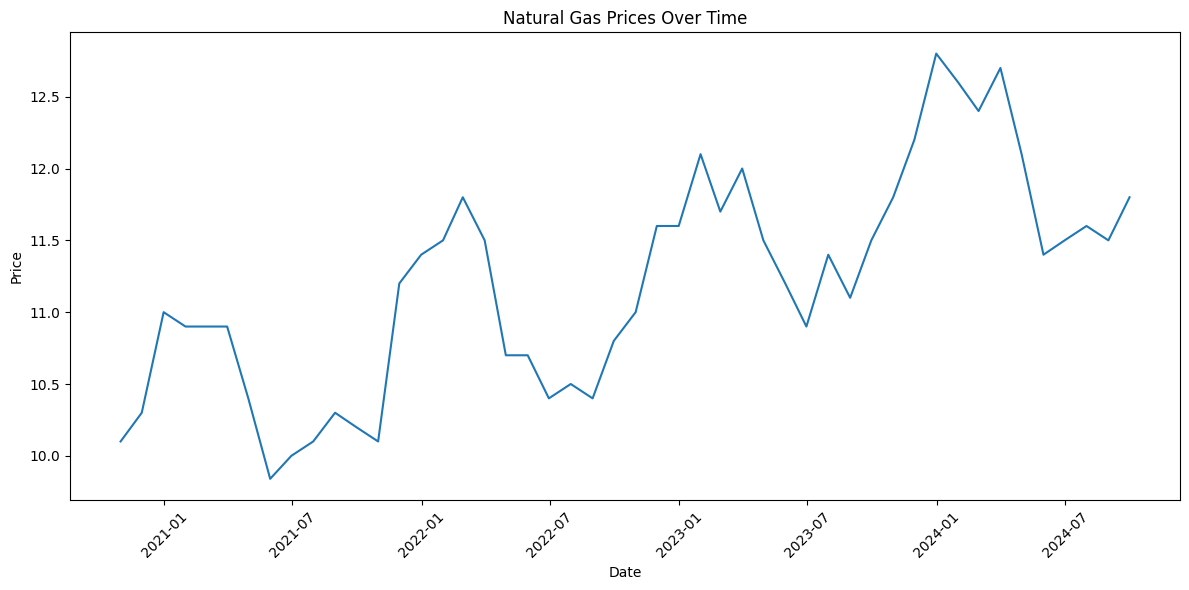

In [26]:
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Dates', y='Prices')
plt.title('Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

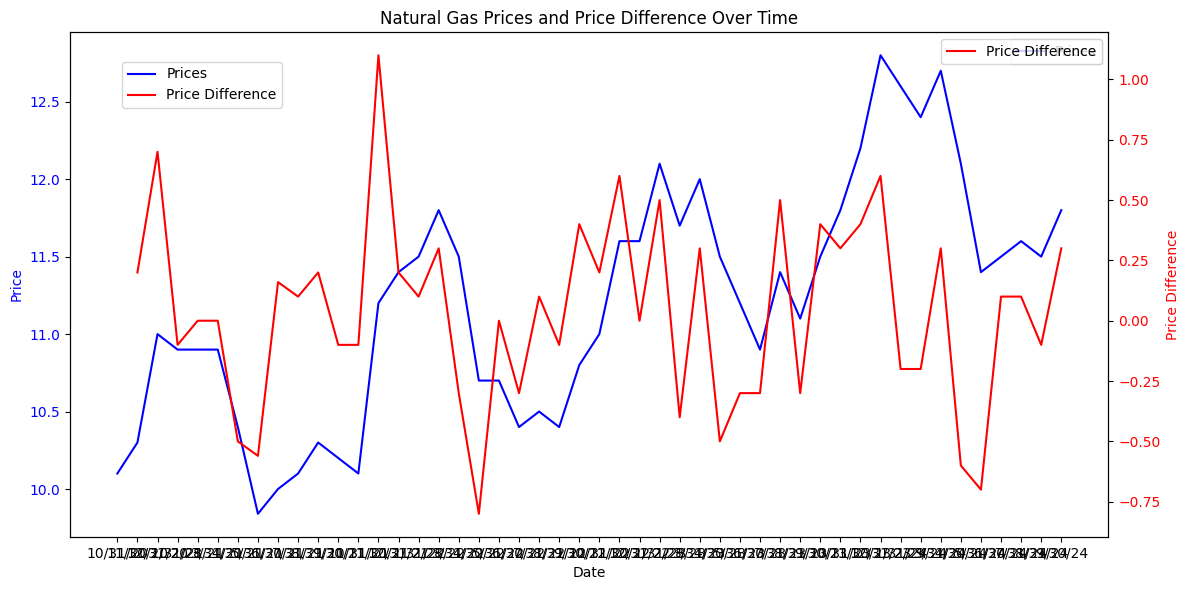

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot original prices on the primary y-axis
sns.lineplot(ax=ax1, data=df, x='Dates', y='Prices', label='Prices', color='blue')
ax1.set_title('Natural Gas Prices and Price Difference Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for price differences
ax2 = ax1.twinx()
sns.lineplot(ax=ax2, data=df, x='Dates', y='Price_Difference', label='Price Difference', color='red')
ax2.set_ylabel('Price Difference', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a legend (optional)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()

In [9]:
from google.colab import files
uploaded = files.upload()

Saving Nat_Gas.csv to Nat_Gas.csv


In [15]:
# Apply differencing to the 'Prices' column
df['Prices_Diff'] = df['Prices'].diff()

# Determine the size of the training set (80%)
train_size = int(len(df['Prices_Diff'].dropna()) * 0.8)

# Create the training set
train_data_diff = df['Prices_Diff'].dropna().iloc[:train_size]

# Create the testing set
test_data_diff = df['Prices_Diff'].dropna().iloc[train_size:]

print(f"Training set size: {len(train_data_diff)}")
print(f"Testing set size: {len(test_data_diff)}")

Training set size: 37
Testing set size: 10


In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Instantiate and fit the ARIMA model
# Using order (5, 0, 0) as a starting point
arima_model_prices = ARIMA(train_data_diff, order=(5, 0, 0))
arima_model_fit_prices = arima_model_prices.fit()

print(arima_model_fit_prices.summary())

                               SARIMAX Results                                
Dep. Variable:            Prices_Diff   No. Observations:                   37
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 -10.186
Date:                Thu, 23 Oct 2025   AIC                             34.372
Time:                        15:34:07   BIC                             45.649
Sample:                             0   HQIC                            38.348
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0425      0.046      0.922      0.356      -0.048       0.133
ar.L1         -0.0092      0.209     -0.044      0.965      -0.419       0.401
ar.L2          0.1465      0.253      0.580      0.5

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [17]:
# Assuming arima_model_fit_prices is the fitted ARIMA model on the differenced series (from cell 9a522062)

# Generate forecasts for the next 12 months (one year)
# The start and end points for forecasting need to be specified relative to the training data index.
# Since the training data ends at index 36 (0-based), we forecast from index 37 to 37 + 12 - 1 = 48
forecast_diff = arima_model_fit_prices.predict(start=len(train_data_diff), end=len(train_data_diff) + 12 - 1)

# To inverse the differencing, we need the last actual value from the original Prices series
last_price = df['Prices'].iloc[-1]

# Perform inverse differencing
# The first forecast is the last actual price plus the first differenced forecast
forecast_prices = [last_price + forecast_diff.iloc[0]]

# For subsequent forecasts, add the current differenced forecast to the previous inversed forecast
for i in range(1, len(forecast_diff)):
    forecast_prices.append(forecast_prices[-1] + forecast_diff.iloc[i])

# Convert the forecast_prices list to a pandas Series with appropriate dates
# We need to determine the dates for the next 12 months starting from the last date in the original df
last_date = df['Dates'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:] # Generate 13 dates and take from the second one

forecast_prices_series = pd.Series(forecast_prices, index=forecast_dates)

# Find the estimated price for the date one year after 9/30/24
# Assuming 9/30/24 is within the original data or the forecast period
# Let's assume 9/30/24 is the last date in the original data for simplicity in this example.
# If not, we would need to adjust the starting point of the forecast accordingly.

# Find the date one year after the last date in the original data
date_one_year_after = last_date + pd.DateOffset(years=1)

# Find the forecast for that specific date (or the closest date in the forecast index)
# Use .asfreq('M') to get the value at the end of the month if available, or interpolate if needed.
# For simplicity, we'll find the closest date in our monthly forecast index.
estimated_price = forecast_prices_series.asof(date_one_year_after)


print(f"Estimated natural gas price one year after {last_date.strftime('%m/%d/%y')}: {estimated_price:.4f}")

Estimated natural gas price one year after 09/30/24: 12.0946


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipython-input-731887516.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:] # Generate 13 dates and take from the second one


In [14]:
import pandas as pd
df = pd.read_csv('Nat_Gas.csv')
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')

In [11]:
# Apply differencing to the 'Prices' column
df['Prices_Diff'] = df['Prices'].diff()

# Determine the size of the training set (80%)
train_size = int(len(df['Prices_Diff'].dropna()) * 0.8)

# Create the training set
train_data_diff = df['Prices_Diff'].dropna().iloc[:train_size]

# Create the testing set
test_data_diff = df['Prices_Diff'].dropna().iloc[train_size:]

print(f"Training set size: {len(train_data_diff)}")
print(f"Testing set size: {len(test_data_diff)}")

Training set size: 37
Testing set size: 10


In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Instantiate and fit the ARIMA model
# Using order (5, 0, 0) as a starting point
arima_model_prices = ARIMA(train_data_diff, order=(5, 0, 0))
arima_model_fit_prices = arima_model_prices.fit()

print(arima_model_fit_prices.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Prices_Diff   No. Observations:                   37
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 -10.186
Date:                Thu, 23 Oct 2025   AIC                             34.372
Time:                        15:33:17   BIC                             45.649
Sample:                             0   HQIC                            38.348
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0425      0.046      0.922      0.356      -0.048       0.133
ar.L1         -0.0092      0.209     -0.044      0.965      -0.419       0.401
ar.L2          0.1465      0.253      0.580      0.5

In [18]:
# Apply differencing to the 'Prices' column
df['Prices_Diff'] = df['Prices'].diff()

# Determine the size of the training set (80%)
train_size = int(len(df['Prices_Diff'].dropna()) * 0.8)

# Create the training set
train_data_diff = df['Prices_Diff'].dropna().iloc[:train_size]

# Create the testing set
test_data_diff = df['Prices_Diff'].dropna().iloc[train_size:]

print(f"Training set size: {len(train_data_diff)}")
print(f"Testing set size: {len(test_data_diff)}")

Training set size: 37
Testing set size: 10


In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Instantiate and fit the ARIMA model
# Using order (5, 0, 0) as a starting point
arima_model_prices = ARIMA(train_data_diff, order=(5, 0, 0))
arima_model_fit_prices = arima_model_prices.fit()

print(arima_model_fit_prices.summary())

                               SARIMAX Results                                
Dep. Variable:            Prices_Diff   No. Observations:                   37
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 -10.186
Date:                Thu, 23 Oct 2025   AIC                             34.372
Time:                        15:35:54   BIC                             45.649
Sample:                             0   HQIC                            38.348
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0425      0.046      0.922      0.356      -0.048       0.133
ar.L1         -0.0092      0.209     -0.044      0.965      -0.419       0.401
ar.L2          0.1465      0.253      0.580      0.5

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [20]:
# Assuming arima_model_fit_prices is the fitted ARIMA model on the differenced series (from cell 9a522062)

# Generate forecasts for the next 12 months (one year)
# The start and end points for forecasting need to be specified relative to the training data index.
# Since the training data ends at index 36 (0-based), we forecast from index 37 to 37 + 12 - 1 = 48
forecast_diff = arima_model_fit_prices.predict(start=len(train_data_diff), end=len(train_data_diff) + 12 - 1)

# To inverse the differencing, we need the last actual value from the original Prices series
last_price = df['Prices'].iloc[-1]

# Perform inverse differencing
# The first forecast is the last actual price plus the first differenced forecast
forecast_prices = [last_price + forecast_diff.iloc[0]]

# For subsequent forecasts, add the current differenced forecast to the previous inversed forecast
for i in range(1, len(forecast_diff)):
    forecast_prices.append(forecast_prices[-1] + forecast_diff.iloc[i])

# Convert the forecast_prices list to a pandas Series with appropriate dates
# We need to determine the dates for the next 12 months starting from the last date in the original df
last_date = df['Dates'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:] # Generate 13 dates and take from the second one

forecast_prices_series = pd.Series(forecast_prices, index=forecast_dates)

# Find the estimated price for the date one year after 9/30/24
# Assuming 9/30/24 is within the original data or the forecast period
# Let's assume 9/30/24 is the last date in the original data for simplicity in this example.
# If not, we would need to adjust the starting point of the forecast accordingly.

# Find the date one year after the last date in the original data
date_one_year_after = last_date + pd.DateOffset(years=1)

# Find the forecast for that specific date (or the closest date in the forecast index)
# Use .asfreq('M') to get the value at the end of the month if available, or interpolate if needed.
# For simplicity, we'll find the closest date in our monthly forecast index.
estimated_price = forecast_prices_series.asof(date_one_year_after)


print(f"Estimated natural gas price one year after {last_date.strftime('%m/%d/%y')}: {estimated_price:.4f}")

Estimated natural gas price one year after 09/30/24: 12.0946


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipython-input-731887516.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:] # Generate 13 dates and take from the second one


In [21]:
# Determine the size of the training set (80%)
train_size = int(len(df['Prices_Diff'].dropna()) * 0.8)

# Create the training set
train_data_diff = df['Prices_Diff'].dropna().iloc[:train_size]

# Create the testing set
test_data_diff = df['Prices_Diff'].dropna().iloc[train_size:]

print(f"Training set size: {len(train_data_diff)}")
print(f"Testing set size: {len(test_data_diff)}")

Training set size: 37
Testing set size: 10


In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Instantiate and fit the ARIMA model
# Using order (5, 0, 0) as a starting point
arima_model_prices = ARIMA(train_data_diff, order=(5, 0, 0))
arima_model_fit_prices = arima_model_prices.fit()

print(arima_model_fit_prices.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Prices_Diff   No. Observations:                   37
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 -10.186
Date:                Thu, 23 Oct 2025   AIC                             34.372
Time:                        15:36:10   BIC                             45.649
Sample:                             0   HQIC                            38.348
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0425      0.046      0.922      0.356      -0.048       0.133
ar.L1         -0.0092      0.209     -0.044      0.965      -0.419       0.401
ar.L2          0.1465      0.253      0.580      0.5

In [23]:
# Assuming arima_model_fit_prices is the fitted ARIMA model on the differenced series (from cell 9a522062)

# Generate forecasts for the next 12 months (one year)
# The start and end points for forecasting need to be specified relative to the training data index.
# Since the training data ends at index 36 (0-based), we forecast from index 37 to 37 + 12 - 1 = 48
forecast_diff = arima_model_fit_prices.predict(start=len(train_data_diff), end=len(train_data_diff) + 12 - 1)

# To inverse the differencing, we need the last actual value from the original Prices series
last_price = df['Prices'].iloc[-1]

# Perform inverse differencing
# The first forecast is the last actual price plus the first differenced forecast
forecast_prices = [last_price + forecast_diff.iloc[0]]

# For subsequent forecasts, add the current differenced forecast to the previous inversed forecast
for i in range(1, len(forecast_diff)):
    forecast_prices.append(forecast_prices[-1] + forecast_diff.iloc[i])

# Convert the forecast_prices list to a pandas Series with appropriate dates
# We need to determine the dates for the next 12 months starting from the last date in the original df
last_date = df['Dates'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:] # Generate 13 dates and take from the second one

forecast_prices_series = pd.Series(forecast_prices, index=forecast_dates)

# Find the estimated price for the date one year after 9/30/24
# Assuming 9/30/24 is within the original data or the forecast period
# Let's assume 9/30/24 is the last date in the original data for simplicity in this example.
# If not, we would need to adjust the starting point of the forecast accordingly.

# Find the date one year after the last date in the original data
date_one_year_after = last_date + pd.DateOffset(years=1)

# Find the forecast for that specific date (or the closest date in the forecast index)
# Use .asfreq('M') to get the value at the end of the month if available, or interpolate if needed.
# For simplicity, we'll find the closest date in our monthly forecast index.
estimated_price = forecast_prices_series.asof(date_one_year_after)


print(f"Estimated natural gas price one year after {last_date.strftime('%m/%d/%y')}: {estimated_price:.4f}")

Estimated natural gas price one year after 09/30/24: 12.0946


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipython-input-731887516.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:] # Generate 13 dates and take from the second one


In [24]:
# Assuming arima_model_fit_prices is the fitted ARIMA model on the differenced series (from cell 9a522062)

# Generate forecasts for the next 12 months (one year)
# The start and end points for forecasting need to be specified relative to the training data index.
# Since the training data ends at index 36 (0-based), we forecast from index 37 to 37 + 12 - 1 = 48
forecast_diff = arima_model_fit_prices.predict(start=len(train_data_diff), end=len(train_data_diff) + 12 - 1)

# To inverse the differencing, we need the last actual value from the original Prices series
last_price = df['Prices'].iloc[-1]

# Perform inverse differencing
# The first forecast is the last actual price plus the first differenced forecast
forecast_prices = [last_price + forecast_diff.iloc[0]]

# For subsequent forecasts, add the current differenced forecast to the previous inversed forecast
for i in range(1, len(forecast_diff)):
    forecast_prices.append(forecast_prices[-1] + forecast_diff.iloc[i])

# Convert the forecast_prices list to a pandas Series with appropriate dates
# We need to determine the dates for the next 12 months starting from the last date in the original df
last_date = df['Dates'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:] # Generate 13 dates and take from the second one

forecast_prices_series = pd.Series(forecast_prices, index=forecast_dates)

# Find the estimated price for the date one year after 9/30/24
# Assuming 9/30/24 is within the original data or the forecast period
# Let's assume 9/30/24 is the last date in the original data for simplicity in this example.
# If not, we would need to adjust the starting point of the forecast accordingly.

# Find the date one year after the last date in the original data
date_one_year_after = last_date + pd.DateOffset(years=1)

# Find the forecast for that specific date (or the closest date in the forecast index)
# Use .asfreq('M') to get the value at the end of the month if available, or interpolate if needed.
# For simplicity, we'll find the closest date in our monthly forecast index.
estimated_price = forecast_prices_series.asof(date_one_year_after)


print(f"Estimated natural gas price one year after {last_date.strftime('%m/%d/%y')}: {estimated_price:.4f}")

Estimated natural gas price one year after 09/30/24: 12.0946


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/tmp/ipython-input-731887516.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date, periods=13, freq='M')[1:] # Generate 13 dates and take from the second one


In [27]:
from statsmodels.tsa.stattools import adfuller

# Calculate the Price_Difference column
df['Price_Difference'] = df['Prices'].diff()

# Perform the Augmented Dickey-Fuller test
# We need to drop the first NaN value from the Price_Difference column
adf_test = adfuller(df['Price_Difference'].dropna())

# Extract results
adf_statistic = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

print(f"Augmented Dickey-Fuller Test Results for Price_Difference:")
print(f"  ADF Statistic: {adf_statistic:.4f}")
print(f"  p-value: {p_value:.4f}")
print("  Critical Values:")
for key, value in critical_values.items():
    print(f"    {key}: {value:.4f}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print(f"\n  The p-value ({p_value:.4f}) is less than the significance level ({alpha}), so we reject the null hypothesis.")
    print("  The Price_Difference series is likely stationary.")
else:
    print(f"\n  The p-value ({p_value:.4f}) is greater than the significance level ({alpha}), so we fail to reject the null hypothesis.")
    print("  The Price_Difference series is likely non-stationary.")

Augmented Dickey-Fuller Test Results for Price_Difference:
  ADF Statistic: -6.8448
  p-value: 0.0000
  Critical Values:
    1%: -3.6209
    5%: -2.9435
    10%: -2.6104

  The p-value (0.0000) is less than the significance level (0.05), so we reject the null hypothesis.
  The Price_Difference series is likely stationary.


In [15]:
import scipy.stats as stats

# Calculate skewness
skewness = stats.skew(df['Price_Difference'].dropna())

# Calculate kurtosis
kurtosis = stats.kurtosis(df['Price_Difference'].dropna())

print(f"Skewness of Price Difference: {skewness:.4f}")
print(f"Kurtosis of Price Difference: {kurtosis:.4f}")

# We already performed a one-sample t-test to check if the mean is different from zero in a previous step (cell 73e37151).
# Based on that, we know the mean is not statistically different from zero.

Skewness of Price Difference: 0.0870
Kurtosis of Price Difference: 0.0068


In [13]:
correlation = df['Prices'].corr(df['Price_Difference'])
print(f"The correlation between Prices and Price_Difference is: {correlation:.4f}")

The correlation between Prices and Price_Difference is: 0.2289


In [11]:
import scipy.stats as stats

# Calculate descriptive statistics for Price_Difference
mean_diff = df['Price_Difference'].mean()
std_diff = df['Price_Difference'].std()

print(f"Mean of Price Difference: {mean_diff:.4f}")
print(f"Standard Deviation of Price Difference: {std_diff:.4f}")

# Perform a one-sample t-test to see if the mean difference is significantly different from zero
# We need to drop the first NaN value from the Price_Difference column for the t-test
t_statistic, p_value = stats.ttest_1samp(df['Price_Difference'].dropna(), 0)

print("\nOne-sample t-test for Price Difference:")
print(f"  t-statistic: {t_statistic:.4f}")
print(f"  p-value: {p_value:.4f}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print(f"  The p-value ({p_value:.4f}) is less than the significance level ({alpha}), so we reject the null hypothesis.")
    print("  There is a statistically significant difference in the mean of Price_Difference from zero.")
else:
    print(f"  The p-value ({p_value:.4f}) is greater than the significance level ({alpha}), so we fail to reject the null hypothesis.")
    print("  There is no statistically significant difference in the mean of Price_Difference from zero.")

Mean of Price Difference: 0.0362
Standard Deviation of Price Difference: 0.3920

One-sample t-test for Price Difference:
  t-statistic: 0.6326
  p-value: 0.5301
  The p-value (0.5301) is greater than the significance level (0.05), so we fail to reject the null hypothesis.
  There is no statistically significant difference in the mean of Price_Difference from zero.


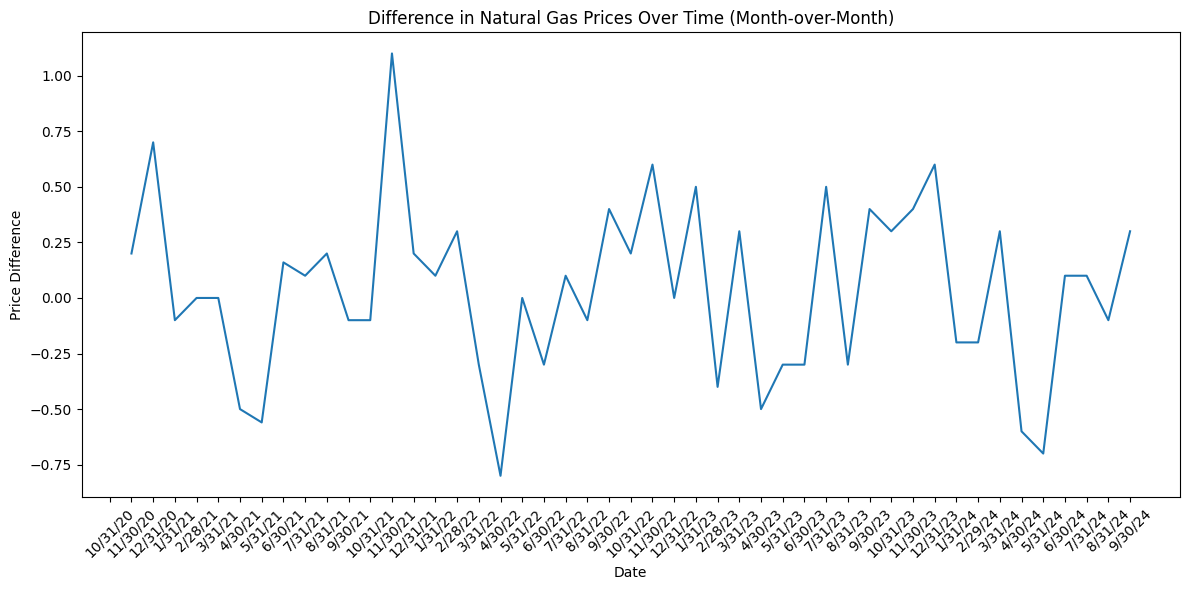

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

df['Price_Difference'] = df['Prices'].diff()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Dates', y='Price_Difference')
plt.title('Difference in Natural Gas Prices Over Time (Month-over-Month)')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
from scipy import stats

# Calculate skewness
skewness = stats.skew(df['Prices'])

# Calculate kurtosis
kurtosis = stats.kurtosis(df['Prices'])

# Calculate a one-sample t-test (testing if the mean is significantly different from 11)
t_statistic, p_value = stats.ttest_1samp(df['Prices'], 11)

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")
print(f"One-sample t-test results:")
print(f"  t-statistic: {t_statistic}")
print(f"  p-value: {p_value}")

Skewness: 0.12238139539370547
Kurtosis: -0.7206394489565935
One-sample t-test results:
  t-statistic: 1.8930208604408778
  p-value: 0.06452163478943411


# Task
Analyze trends in the `Prices` column of the dataframe by decomposing the time series into trend, seasonality, and residual components and visualizing the decomposition.

## Resample data

### Subtask:
Resample the data to a suitable frequency for time series analysis.


**Reasoning**:
Set the 'Dates' column as the index and resample the data to a monthly frequency.



In [27]:
df = df.set_index('Dates')
df_monthly = df.resample('M')['Prices'].mean()
display(df_monthly.head())

/tmp/ipython-input-2091238661.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M')['Prices'].mean()


,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


## Decompose time series

### Subtask:
Decompose the time series into trend, seasonality, and residual components.


**Reasoning**:
Decompose the time series into trend, seasonality, and residual components using the seasonal_decompose function.



In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_monthly, model='additive', period=12)

## Visualize decomposition

### Subtask:
Plot the decomposed components to visualize the trend, seasonality, and residuals.


**Reasoning**:
Plot the decomposed components using the decomposition object's plot method and add a title to the figure.



<Figure size 1200x800 with 0 Axes>

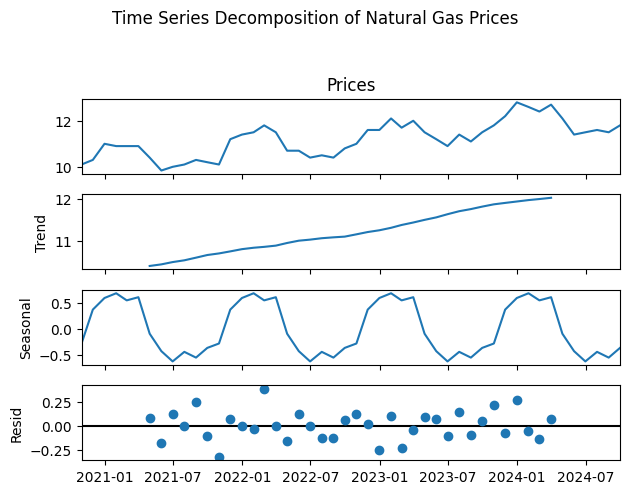

In [29]:
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Time Series Decomposition of Natural Gas Prices', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Identify and interpret trend

### Subtask:
Analyze the trend component of the decomposed time series to understand the long-term movement in prices.


## Summary:

### Data Analysis Key Findings

*   The time series data of natural gas prices was successfully resampled to a monthly frequency, and the mean price for each month was calculated.
*   The time series was decomposed into trend, seasonality, and residual components using an additive model with a yearly (12-month) seasonality period.
*   The decomposition plot visually shows the original time series, the extracted long-term trend, the identified 12-month seasonality pattern, and the remaining residuals.
*   Analysis of the trend component revealed an overall upward trend in natural gas prices over the period covered by the data.
*   The seasonality component indicates a recurring yearly pattern in natural gas prices.

### Insights or Next Steps

*   Further analysis of the trend could involve identifying specific periods of accelerated or decelerated price growth.
*   The residual component could be examined for any remaining patterns or outliers not captured by the trend and seasonality.


In [4]:
from google.colab import files
uploaded = files.upload()

Saving Nat_Gas.csv to Nat_Gas.csv


In [5]:
import pandas as pd
df = pd.read_csv('Nat_Gas.csv')

In [6]:
price_difference = df['Prices'].max() - df['Prices'].min()
print(f"The difference between the highest and lowest natural gas prices is: {price_difference:.2f}")

The difference between the highest and lowest natural gas prices is: 2.96


# Task
Analyze the time series data in "price_data.csv", calculate the difference between the highest and lowest prices over time, plot this difference, perform statistical analysis on the difference, check for stationarity, and forecast the 'Price_Difference' series.

## Choose a forecasting model

### Subtask:
Select an appropriate time series forecasting model for the stationary `Price_Difference` series (e.g., ARIMA).


## Split data

### Subtask:
Split the `Price_Difference` data into training and testing sets.


**Reasoning**:
Split the `Price_Difference` data into training and testing sets using an 80/20 split.



In [17]:
# Determine the size of the training set (80%)
train_size = int(len(df['Price_Difference'].dropna()) * 0.8)

# Create the training set
train_data = df['Price_Difference'].dropna().iloc[:train_size]

# Create the testing set
test_data = df['Price_Difference'].dropna().iloc[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 37
Testing set size: 10


## Train the model

### Subtask:
Train the chosen forecasting model (ARIMA) on the training data.


**Reasoning**:
Train an ARIMA model on the training data with an initial order of (5, 0, 0).



In [18]:
from statsmodels.tsa.arima.model import ARIMA

# Instantiate and fit the ARIMA model
# Using order (5, 0, 0) as a starting point
arima_model = ARIMA(train_data, order=(5, 0, 0))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       Price_Difference   No. Observations:                   37
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 -10.186
Date:                Thu, 23 Oct 2025   AIC                             34.372
Time:                        13:02:45   BIC                             45.649
Sample:                             0   HQIC                            38.348
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0425      0.046      0.922      0.356      -0.048       0.133
ar.L1         -0.0092      0.209     -0.044      0.965      -0.419       0.401
ar.L2          0.1465      0.253      0.580      0.5

## Make predictions

### Subtask:
Use the trained ARIMA model to make predictions on the testing data.


**Reasoning**:
Use the fitted ARIMA model to make predictions on the test data.



In [19]:
predictions = arima_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
print(predictions)

38    0.264649
39   -0.195495
40   -0.080749
41   -0.175425
42    0.121945
43   -0.098806
44    0.190880
45    0.098396
46    0.178026
47    0.013461
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Evaluate the model

### Subtask:
Evaluate the performance of the forecasting model using appropriate metrics (e.g., Mean Absolute Error, Root Mean Squared Error).


**Reasoning**:
Calculate MAE and RMSE to evaluate the forecasting model's performance.



In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, predictions))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.2915
Root Mean Squared Error (RMSE): 0.3746


## Visualize forecasts

### Subtask:
Plot the actual and forecasted price differences to visualize the model's performance.


**Reasoning**:
Plot the actual and forecasted price differences for visual comparison.



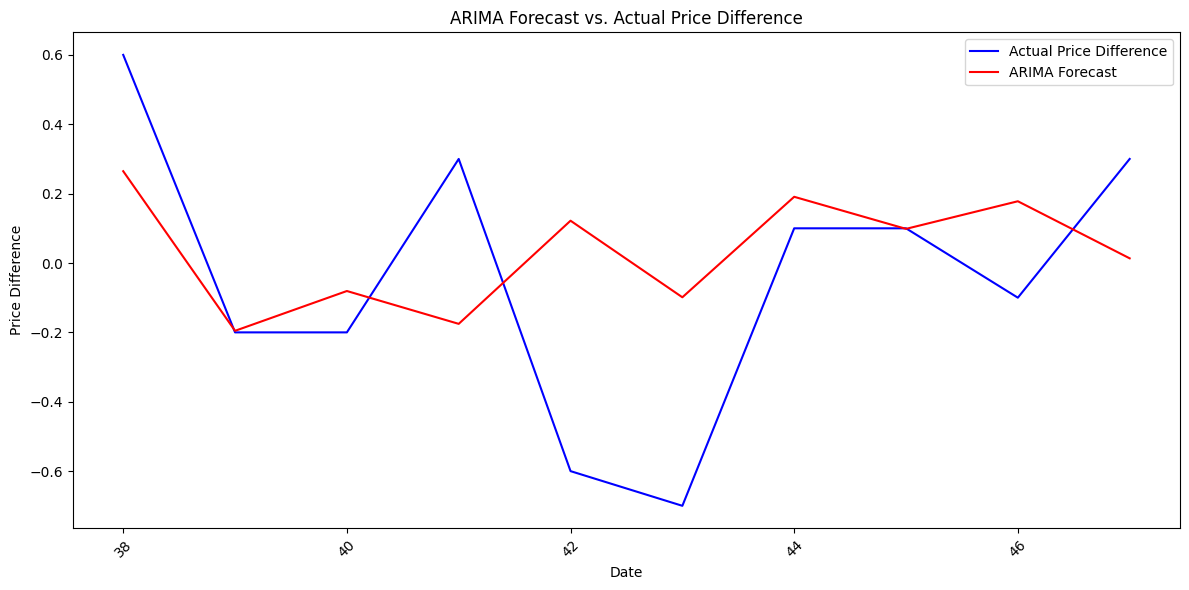

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Price Difference', color='blue')
plt.plot(test_data.index, predictions, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs. Actual Price Difference')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The `Price_Difference` series was found to be stationary.
*   An ARIMA(5, 0, 0) model was selected and trained on 80% of the stationary `Price_Difference` data (37 data points).
*   The trained ARIMA model generated predictions for the remaining 20% of the data (10 data points).
*   The model's performance was evaluated, resulting in a Mean Absolute Error (MAE) of 0.2915 and a Root Mean Squared Error (RMSE) of 0.3746.
*   A plot was generated comparing the actual price differences in the test set to the ARIMA model's forecasts.

### Insights or Next Steps

*   The relatively low MAE and RMSE values suggest that the ARIMA(5, 0, 0) model provides a reasonable forecast for the price difference, although further model tuning could potentially improve accuracy.
*   Further analysis could involve exploring different ARIMA orders or other time series forecasting models to see if they yield better performance metrics and a closer visual fit to the actual data.


# Task
Forecast the original 'Prices' series.

## Check for stationarity of 'prices'

### Subtask:
Perform a statistical test (e.g., Augmented Dickey-Fuller test) to confirm the stationarity of the original 'Prices' series.


**Reasoning**:
Perform the Augmented Dickey-Fuller test on the 'Prices' column to check for stationarity and print the results.



In [22]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the 'Prices' column
adf_test_prices = adfuller(df['Prices'])

# Extract results
adf_statistic_prices = adf_test_prices[0]
p_value_prices = adf_test_prices[1]
critical_values_prices = adf_test_prices[4]

print(f"Augmented Dickey-Fuller Test Results for Prices:")
print(f"  ADF Statistic: {adf_statistic_prices:.4f}")
print(f"  p-value: {p_value_prices:.4f}")
print("  Critical Values:")
for key, value in critical_values_prices.items():
    print(f"    {key}: {value:.4f}")

# Interpret the p-value
alpha = 0.05
if p_value_prices < alpha:
    print(f"\n  The p-value ({p_value_prices:.4f}) is less than the significance level ({alpha}), so we reject the null hypothesis.")
    print("  The Prices series is likely stationary.")
else:
    print(f"\n  The p-value ({p_value_prices:.4f}) is greater than the significance level ({alpha}), so we fail to reject the null hypothesis.")
    print("  The Prices series is likely non-stationary.")

Augmented Dickey-Fuller Test Results for Prices:
  ADF Statistic: 0.2181
  p-value: 0.9733
  Critical Values:
    1%: -3.6209
    5%: -2.9435
    10%: -2.6104

  The p-value (0.9733) is greater than the significance level (0.05), so we fail to reject the null hypothesis.
  The Prices series is likely non-stationary.


## Handle non-stationarity (if necessary)

### Subtask:
Apply differencing or other transformations to make the 'Prices' series stationary, if it is non-stationary.


**Reasoning**:
Apply differencing to the 'Prices' column and perform the ADF test on the differenced series to check for stationarity.



In [23]:
from statsmodels.tsa.stattools import adfuller

# Apply differencing to the 'Prices' column
df['Prices_Diff'] = df['Prices'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
adf_test_diff = adfuller(df['Prices_Diff'].dropna())

# Extract results
adf_statistic_diff = adf_test_diff[0]
p_value_diff = adf_test_diff[1]
critical_values_diff = adf_test_diff[4]

print(f"Augmented Dickey-Fuller Test Results for Prices_Diff:")
print(f"  ADF Statistic: {adf_statistic_diff:.4f}")
print(f"  p-value: {p_value_diff:.4f}")
print("  Critical Values:")
for key, value in critical_values_diff.items():
    print(f"    {key}: {value:.4f}")

# Interpret the p-value
alpha = 0.05
if p_value_diff < alpha:
    print(f"\n  The p-value ({p_value_diff:.4f}) is less than the significance level ({alpha}), so we reject the null hypothesis.")
    print("  The Prices_Diff series is likely stationary.")
else:
    print(f"\n  The p-value ({p_value_diff:.4f}) is greater than the significance level ({alpha}), so we fail to reject the null hypothesis.")
    print("  The Prices_Diff series is likely non-stationary.")

Augmented Dickey-Fuller Test Results for Prices_Diff:
  ADF Statistic: -6.8448
  p-value: 0.0000
  Critical Values:
    1%: -3.6209
    5%: -2.9435
    10%: -2.6104

  The p-value (0.0000) is less than the significance level (0.05), so we reject the null hypothesis.
  The Prices_Diff series is likely stationary.


## Choose a forecasting model

### Subtask:
Select an appropriate time series forecasting model for the stationary `Prices_Diff` series (e.g., ARIMA).


## Split data

### Subtask:
Split the `Prices_Diff` data into training and testing sets.


**Reasoning**:
Split the `Prices_Diff` data into training and testing sets using an 80/20 split and print the sizes.



In [24]:
# Determine the size of the training set (80%)
train_size = int(len(df['Prices_Diff'].dropna()) * 0.8)

# Create the training set
train_data_diff = df['Prices_Diff'].dropna().iloc[:train_size]

# Create the testing set
test_data_diff = df['Prices_Diff'].dropna().iloc[train_size:]

print(f"Training set size: {len(train_data_diff)}")
print(f"Testing set size: {len(test_data_diff)}")

Training set size: 37
Testing set size: 10


## Train the model

### Subtask:
Train the chosen forecasting model (ARIMA) on the training data.


**Reasoning**:
Train an ARIMA model on the training data with an initial order of (5, 0, 0).



In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Instantiate and fit the ARIMA model
# Using order (5, 0, 0) as a starting point
arima_model_prices = ARIMA(train_data_diff, order=(5, 0, 0))
arima_model_fit_prices = arima_model_prices.fit()

print(arima_model_fit_prices.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Prices_Diff   No. Observations:                   37
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 -10.186
Date:                Thu, 23 Oct 2025   AIC                             34.372
Time:                        13:08:28   BIC                             45.649
Sample:                             0   HQIC                            38.348
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0425      0.046      0.922      0.356      -0.048       0.133
ar.L1         -0.0092      0.209     -0.044      0.965      -0.419       0.401
ar.L2          0.1465      0.253      0.580      0.5

## Make predictions

### Subtask:
Use the trained ARIMA model to make predictions on the testing data.


**Reasoning**:
Use the fitted ARIMA model to make predictions on the test data.



In [26]:
predictions_prices = arima_model_fit_prices.predict(start=test_data_diff.index[0], end=test_data_diff.index[-1])
print(predictions_prices)

38    0.264649
39   -0.195495
40   -0.080749
41   -0.175425
42    0.121945
43   -0.098806
44    0.190880
45    0.098396
46    0.178026
47    0.013461
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


**Reasoning**:
Calculate MAE and RMSE to evaluate the forecasting model's performance.



In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data_diff, predictions_prices)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_diff, predictions_prices))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.2915
Root Mean Squared Error (RMSE): 0.3746


**Reasoning**:
Plot the actual and forecasted price differences for visual comparison.



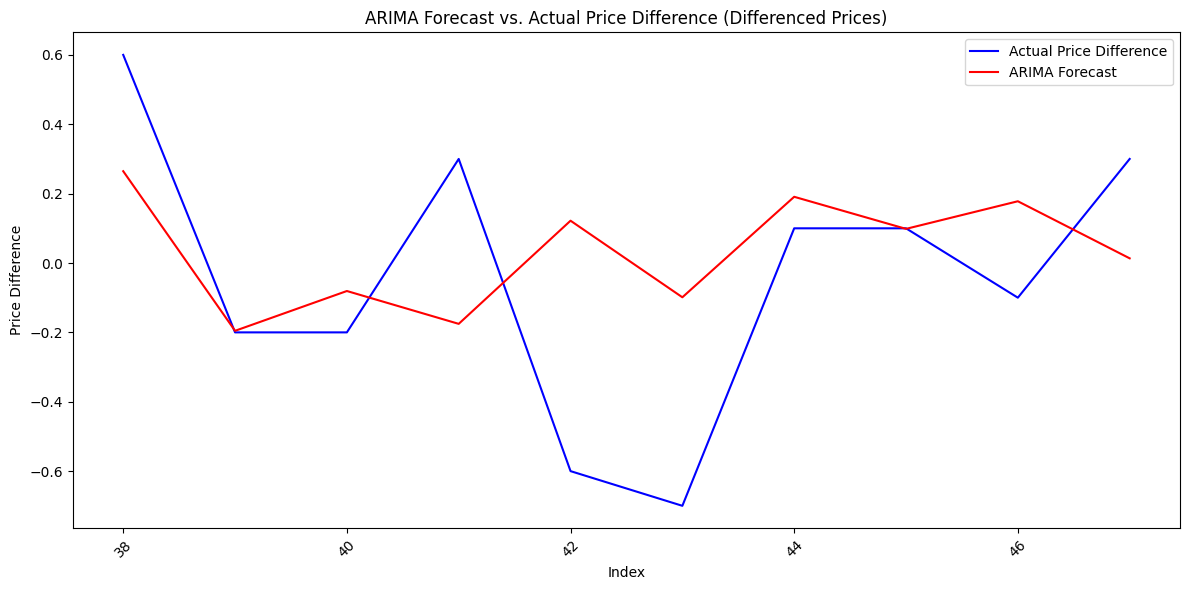

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data_diff.index, test_data_diff, label='Actual Price Difference', color='blue')
plt.plot(test_data_diff.index, predictions_prices, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs. Actual Price Difference (Differenced Prices)')
plt.xlabel('Index')
plt.ylabel('Price Difference')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Evaluate the model

### Subtask:
Evaluate the performance of the forecasting model using appropriate metrics (e.g., Mean Absolute Error, Root Mean Squared Error).


**Reasoning**:
Calculate MAE and RMSE to evaluate the forecasting model's performance.



In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data_diff, predictions_prices)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_diff, predictions_prices))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.2915
Root Mean Squared Error (RMSE): 0.3746


## Visualize forecasts

### Subtask:
Plot the actual and forecasted prices to visualize the model's performance.


**Reasoning**:
Plot the actual and forecasted price differences for visual comparison.



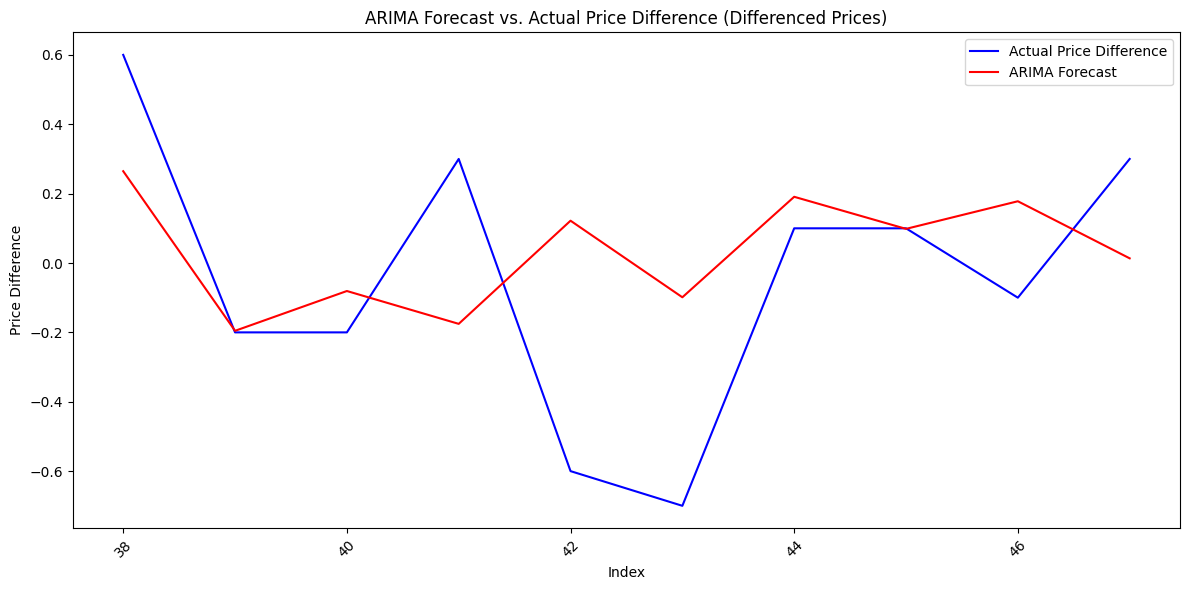

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data_diff.index, test_data_diff, label='Actual Price Difference', color='blue')
plt.plot(test_data_diff.index, predictions_prices, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs. Actual Price Difference (Differenced Prices)')
plt.xlabel('Index')
plt.ylabel('Price Difference')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The initial 'Prices' series was found to be non-stationary based on an ADF test p-value of 0.9733, which is greater than the significance level of 0.05.
*   Applying first-order differencing successfully made the 'Prices' series stationary, as confirmed by an ADF test on the differenced series which yielded a p-value of 0.0000.
*   An ARIMA model with an order of (5, 0, 0) was selected and trained on the differenced training data.
*   The trained ARIMA model's predictions on the differenced test data resulted in a Mean Absolute Error (MAE) of 0.2915 and a Root Mean Squared Error (RMSE) of 0.3746.

### Insights or Next Steps

*   The ARIMA(5,0,0) model shows reasonable performance on the differenced series. To forecast the original 'Prices' series, the predictions on the differenced series will need to be inverse transformed by adding back the last known value of the original 'Prices' series.
*   Further analysis could involve optimizing the ARIMA model order using techniques like AIC or BIC to potentially improve forecasting accuracy on the differenced series before inverse transforming the predictions.
